# Implementación de un Detrend Simple (Asistido por DeepSeek)

- **Autor: A.Isaac P.S.**

- **Resumen**: En el procesamiento de señales sísmicas, el detrend (eliminación de tendencia) es una operación fundamental para remover componentes de baja frecuencia que no están relacionados con el movimiento sísmico real, sino con drift instrumental o otras fuentes de ruido electrónico.

- Concepto Básico:
El detrend más simple consiste en remover la media de la señal, lo que equivale a centrar la señal en cero:

$$S_{Detrend} = S_{Original} - μ$$

Donde:

- $S_{Original}$ es la señal original,
- $S_{Detrend}$ es la señal detrend y
- $μ = mean(S_{Original})$ es el valor promedio de la señal original.

## Implementación Básica

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

def remove_trend_simple(signal_data):
    """
    Remueve la tendencia (componente DC) de una señal
    
    Args:
        signal_data: Array con los datos de la señal
        
    Returns:
        Detrended signal: Señal con tendencia removida
    """
    mean = np.mean(signal_data)
    detrend_signal = signal_data - mean
    return detrend_signal

## Ejemplo con Señal Sintética

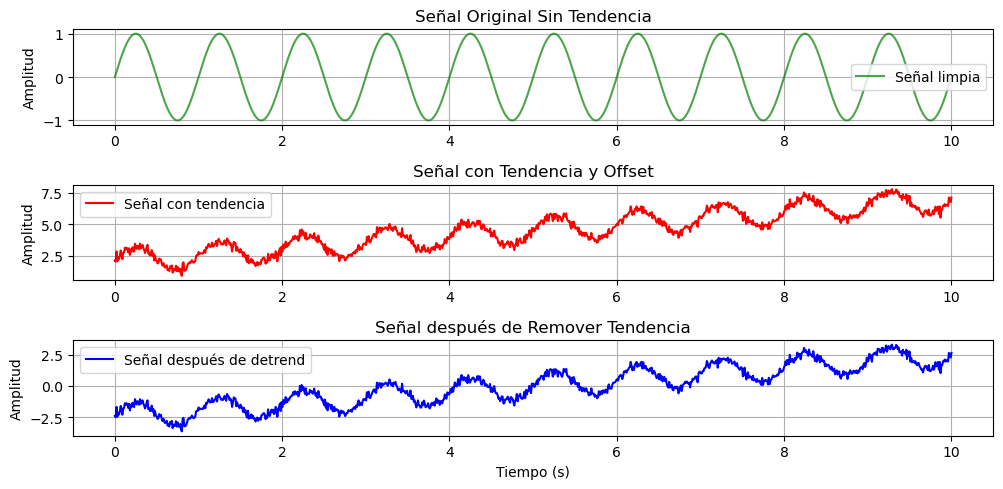

In [15]:
# Crear una señal sintética con tendencia
t = np.linspace(0, 10, 1000)  # 10 segundos de datos
signal_clean = np.sin(2 * np.pi * 1.0 * t)  # Señal limpia (1 Hz)

# Agregar tendencia lineal y offset
trend = 0.5 * t + 2.0  # Tendencia lineal + offset
signal_with_trend = signal_clean + trend + 0.2 * np.random.normal(size=len(t))

# Aplicar detrend
signal_detrended = remove_trend_simple(signal_with_trend)

# Visualizar
plt.figure(figsize=(10, 5))

plt.subplot(3, 1, 1)
plt.plot(t, signal_clean, 'g-', alpha=0.7, label='Señal limpia')
plt.title('Señal Original Sin Tendencia')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, signal_with_trend, 'r-', label='Señal con tendencia')
plt.title('Señal con Tendencia y Offset')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, signal_detrended, 'b-', label='Señal después de detrend')
plt.title('Señal después de Remover Tendencia')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Detrend en Tiempo Real

En tiempo real, no podemos calcular la media de todos los datos porque:

- No tenemos acceso a datos futuros

- El cálculo sería computacionalmente costoso

- Necesitamos procesar datos incrementalmente

### Solución: Media Móvil
Para tiempo real, usamos una media móvil que se actualiza con cada nueva muestra:

In [18]:
class RealTimeDetrender:
    """
    Implementación de detrend en tiempo real usando media móvil
    """
    
    def __init__(self, window_size=100, initial_mean=0.0):
        """
        Inicializa el detrender en tiempo real
        
        Args:
            window_size: Tamaño de la ventana para calcular media móvil
            initial_mean: Valor inicial para la media
        """
        self.window_size = window_size
        self.current_mean = initial_mean
        self.data_window = np.array([])
        self.sample_count = 0
        
    def update_detrend(self, new_data):
        """
        Procesa nuevos datos y aplica detrend en tiempo real
        
        Args:
            new_data: Nuevos datos a procesar (puede ser escalar o array)
            
        Returns:
            Datos con tendencia removida
        """
        new_data = np.asarray(new_data)
        detrended_data = []
        
        for sample in new_data:
            # Actualizar ventana de datos
            if len(self.data_window) >= self.window_size:
                self.data_window = np.append(self.data_window[1:], sample)
            else:
                self.data_window = np.append(self.data_window, sample)
            
            # Calcular nueva media (podría optimizarse incrementalmente)
            self.current_mean = np.mean(self.data_window)
            
            # Aplicar detrend
            detrended_sample = sample - self.current_mean
            detrended_data.append(detrended_sample)
            
            self.sample_count += 1
        
        return np.array(detrended_data)
    
    def get_current_stats(self):
        """Retorna estadísticas actuales"""
        return {
            'current_mean': self.current_mean,
            'window_size': len(self.data_window),
            'total_samples_processed': self.sample_count
        }

## Prueba del Detrend en Tiempo Real

Muestras procesadas: 10, Media actual: 2.244
Muestras procesadas: 210, Media actual: 2.113
Muestras procesadas: 410, Media actual: 2.322
Muestras procesadas: 610, Media actual: 2.180
Muestras procesadas: 810, Media actual: 1.538
Muestras procesadas: 1010, Media actual: 1.049
Muestras procesadas: 1210, Media actual: 1.475
Muestras procesadas: 1410, Media actual: 2.668
Muestras procesadas: 1610, Media actual: 3.528
Muestras procesadas: 1810, Media actual: 2.999


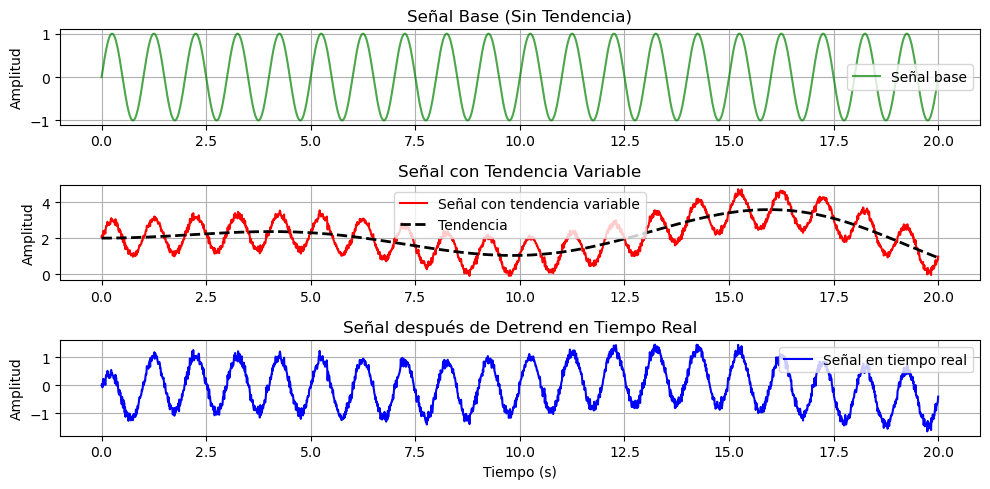

In [21]:
# Crear señal de prueba con tendencia variable
t = np.linspace(0, 20, 2000)  # 20 segundos de datos
signal_base = np.sin(2 * np.pi * 1.0 * t)  # Señal base 1 Hz

# Tendencia que cambia con el tiempo
changing_trend = 0.1 * t * np.sin(0.5 * t) + 2.0
signal_with_changing_trend = signal_base + changing_trend + 0.1 * np.random.normal(size=len(t))

# Inicializar detrender en tiempo real
detrender = RealTimeDetrender(window_size=100)

# Simular procesamiento en tiempo real (chunks de 10 muestras)
chunk_size = 10
detrended_signal = []

for i in range(0, len(signal_with_changing_trend), chunk_size):
    chunk = signal_with_changing_trend[i:i+chunk_size]
    processed_chunk = detrender.update_detrend(chunk)
    detrended_signal.extend(processed_chunk)
    
    # Mostrar progreso cada 100 muestras
    if i % 200 == 0:
        stats = detrender.get_current_stats()
        print(f"Muestras procesadas: {stats['total_samples_processed']}, Media actual: {stats['current_mean']:.3f}")

detrended_signal = np.array(detrended_signal)

# Visualizar resultados
plt.figure(figsize=(10, 5))

plt.subplot(3, 1, 1)
plt.plot(t, signal_base, 'g-', alpha=0.7, label='Señal base')
plt.title('Señal Base (Sin Tendencia)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, signal_with_changing_trend, 'r-', label='Señal con tendencia variable')
plt.plot(t, changing_trend, 'k--', label='Tendencia', linewidth=2)
plt.title('Señal con Tendencia Variable')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, detrended_signal, 'b-', label='Señal en tiempo real')
plt.title('Señal después de Detrend en Tiempo Real')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Implementación Optimizada para Tiempo Real

In [24]:
class OptimizedRealTimeDetrender:
    """
    Implementación optimizada de detrend en tiempo real
    con cálculo incremental de la media
    """
    
    def __init__(self, window_size=100):
        """
        Inicializa el detrender optimizado
        
        Args:
            window_size: Tamaño de la ventana deslizante
        """
        self.window_size = window_size
        self.data_window = np.zeros(window_size)
        self.current_sum = 0.0
        self.current_mean = 0.0
        self.sample_count = 0
        self.window_index = 0
        self.window_filled = False
        
    def update_detrend_optimized(self, new_data):
        """
        Procesa nuevos datos con cálculo incremental de la media
        
        Args:
            new_data: Nuevos datos a procesar
            
        Returns:
            Datos con tendencia removida
        """
        new_data = np.asarray(new_data)
        detrended_data = []
        
        for sample in new_data:
            # Actualizar suma de manera incremental
            if self.window_filled:
                # Ventana llena: restar el valor más antiguo
                self.current_sum -= self.data_window[self.window_index]
            
            # Agregar nuevo valor a la suma
            self.current_sum += sample
            
            # Almacenar nuevo valor en la ventana
            self.data_window[self.window_index] = sample
            
            # Calcular media actual
            effective_window_size = self.window_size if self.window_filled else (self.window_index + 1)
            self.current_mean = self.current_sum / effective_window_size
            
            # Aplicar detrend
            detrended_sample = sample - self.current_mean
            detrended_data.append(detrended_sample)
            
            # Actualizar índice circular
            self.window_index = (self.window_index + 1) % self.window_size
            if self.window_index == 0:
                self.window_filled = True
            
            self.sample_count += 1
        
        return np.array(detrended_data)
    
    def get_stats(self):
        """Retorna estadísticas actuales"""
        effective_size = self.window_size if self.window_filled else self.window_index
        return {
            'current_mean': self.current_mean,
            'window_filled': self.window_filled,
            'effective_window_size': effective_size,
            'total_samples_processed': self.sample_count
        }

## Comparación de Implementaciones

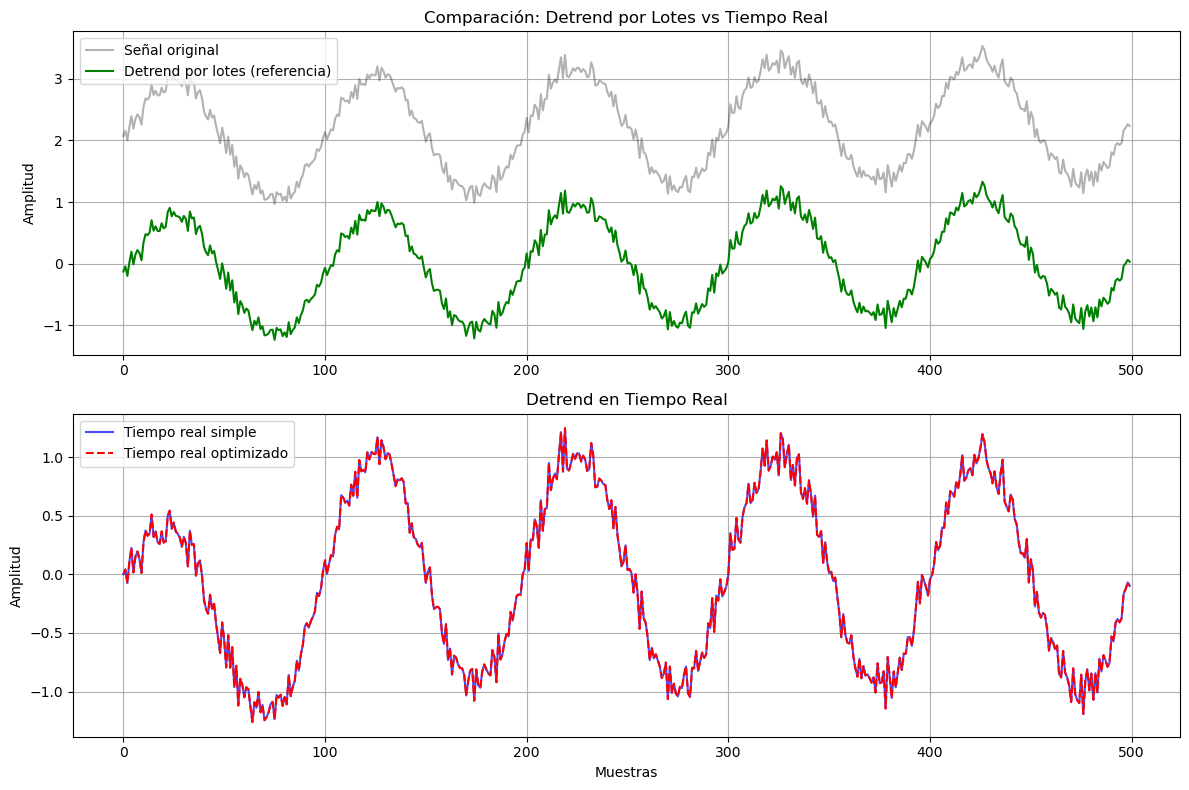

Estadísticas implementación optimizada:
current_mean: 2.3327490573181477
window_filled: True
effective_window_size: 100
total_samples_processed: 500


In [26]:
# Probar ambas implementaciones
signal_test = signal_with_changing_trend[:500]  # Usar primeros 500 puntos

# Implementación simple (referencia)
detrended_reference = remove_trend_simple(signal_test)

# Implementación en tiempo real
detrender_simple = RealTimeDetrender(window_size=100)
detrended_simple = detrender_simple.update_detrend(signal_test)

# Implementación optimizada
detrender_opt = OptimizedRealTimeDetrender(window_size=100)
detrended_opt = detrender_opt.update_detrend_optimized(signal_test)

# Comparar resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(signal_test, 'k-', alpha=0.3, label='Señal original')
plt.plot(detrended_reference, 'g-', label='Detrend por lotes (referencia)')
plt.title('Comparación: Detrend por Lotes vs Tiempo Real')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(detrended_simple, 'b-', alpha=0.7, label='Tiempo real simple')
plt.plot(detrended_opt, 'r--', label='Tiempo real optimizado')
plt.title('Detrend en Tiempo Real')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Mostrar estadísticas de rendimiento
print("Estadísticas implementación optimizada:")
stats = detrender_opt.get_stats()
for key, value in stats.items():
    print(f"{key}: {value}")

## Implementación para datos sísmicos en el arreglo de SkyAlert

In [29]:
class SeismicDetrender:
    """
    Detrender especializado para datos sísmicos en formato ENZ
    """
    
    def __init__(self, window_size=100):
        self.detrender = OptimizedRealTimeDetrender(window_size)
        self.processed_data = []
        self.timestamps = []
        
    def process_enz_chunk(self, enz_data):
        """
        Procesa un chunk de datos en formato ENZ
        
        Args:
            enz_data: Tupla con formato ('ENZ', timestamp, data1, data2, ...)
            
        Returns:
            Diccionario con resultados del procesamiento
        """
        try:
            channel = enz_data[0]
            timestamp = enz_data[1]
            data = np.array(enz_data[2:])
            
            # Aplicar detrend en tiempo real
            detrended_data = self.detrender.update_detrend_optimized(data)
            
            # Almacenar resultados
            if len(detrended_data) > 0:
                self.processed_data.extend(detrended_data)
                # Asumimos intervalo constante entre muestras (ajustar según tu caso)
                time_increment = 0.25  # 250ms entre muestras
                new_timestamps = [timestamp + i * time_increment for i in range(len(detrended_data))]
                self.timestamps.extend(new_timestamps)
            
            return {
                'channel': channel,
                'timestamp': timestamp,
                'original_samples': len(data),
                'detrended_samples': len(detrended_data),
                'current_mean': self.detrender.current_mean,
                'success': True
            }
            
        except Exception as e:
            return {
                'channel': enz_data[0] if len(enz_data) > 0 else 'UNKNOWN',
                'error': str(e),
                'success': False
            }

## Prueba con Datos Simulados

In [36]:
# Datos ENZ reales proporcionados
enz_chunk = ('ENZ', 1507760140.530, 614, 916, 1095, 1156, 839, 923, 861, 856, 861, 
             789, 568, 823, 965, 788, 835, 991, 1028, 1225, 1142, 828, 682, 635, 
             771, 978, 834, 1167, 1116, 888, 627, 564, 944, 994, 780, 652, 811, 
             915, 832, 1134, 1020, 594, 756, 782, 748, 810, 864, 936, 977, 1014, 
             676, 502)

# Extraer los datos
channel = enz_chunk[0]
timestamp = enz_chunk[1]
data = np.array(enz_chunk[2:])

print(f"Canal: {channel}")
print(f"Timestamp inicial: {timestamp}")
print(f"Número de muestras: {len(data)}")
print(f"Valores iniciales: {data[:5]}...")
print(f"Valores finales: {data[-5:]}...")

# Calcular estadísticas básicas
print(f"\nEstadísticas de los datos:")
print(f"Media: {np.mean(data):.2f}")
print(f"Desviación estándar: {np.std(data):.2f}")
print(f"Mínimo: {np.min(data)}")
print(f"Máximo: {np.max(data)}")
print(f"Rango: {np.max(data) - np.min(data)}")

Canal: ENZ
Timestamp inicial: 1507760140.53
Número de muestras: 50
Valores iniciales: [ 614  916 1095 1156  839]...
Valores finales: [ 936  977 1014  676  502]...

Estadísticas de los datos:
Media: 862.12
Desviación estándar: 171.76
Mínimo: 502
Máximo: 1225
Rango: 723


## Procesamiento con diferentes tamaños de ventana

In [39]:
# Probar diferentes tamaños de ventana para ver el efecto
window_sizes = [10, 25, 50, 100]
results = {}

for window_size in window_sizes:
    detrender = OptimizedRealTimeDetrender(window_size=window_size)
    detrended_data = detrender.update_detrend_optimized(data)
    results[window_size] = {
        'detrended_data': detrended_data,
        'final_mean': detrender.current_mean,
        'window_filled': detrender.window_filled
    }
    print(f"Ventana {window_size}: Media final = {detrender.current_mean:.2f}")

# También calcular el detrend por lotes (referencia)
detrended_reference = remove_trend_simple(data)

Ventana 10: Media final = 806.50
Ventana 25: Media final = 844.12
Ventana 50: Media final = 862.12
Ventana 100: Media final = 862.12


## Visualización

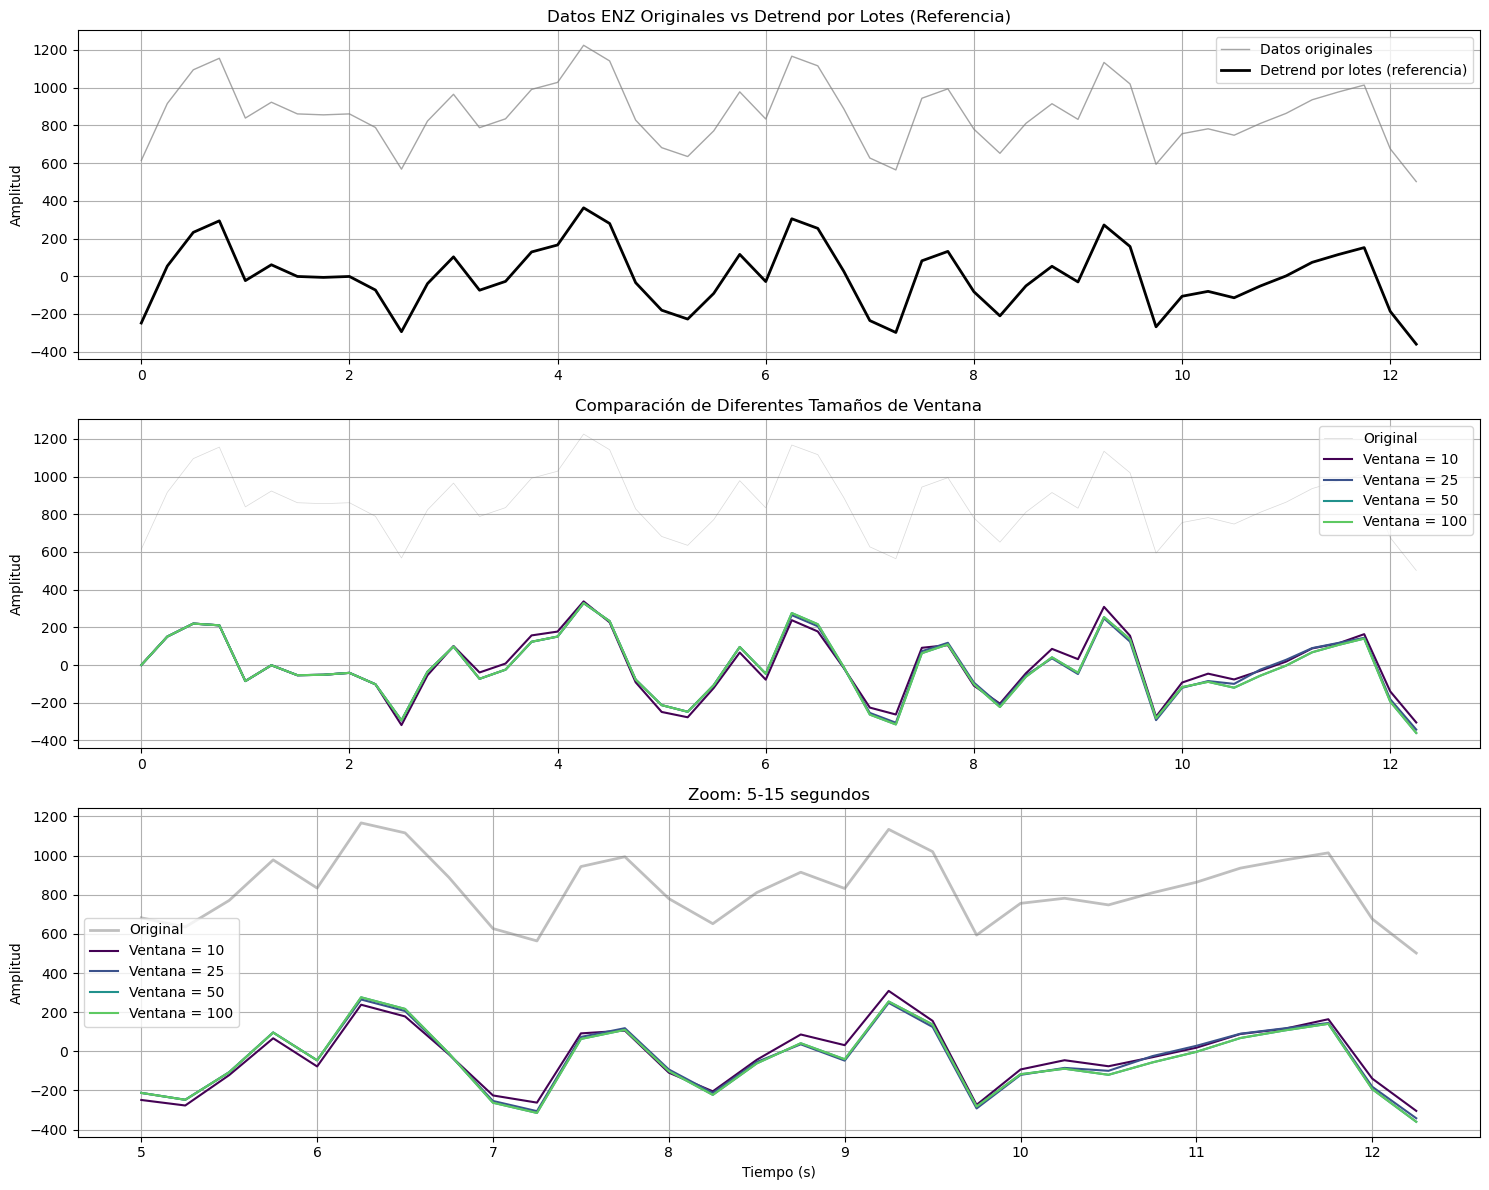

In [42]:
# Crear vector de tiempo (asumiendo 4 Hz = 0.25s entre muestras)
time_seconds = np.arange(len(data)) * 0.25

plt.figure(figsize=(15, 12))

# Gráfico 1: Datos originales vs Detrend por lotes (referencia)
plt.subplot(3, 1, 1)
plt.plot(time_seconds, data, 'gray', alpha=0.7, linewidth=1, label='Datos originales')
plt.plot(time_seconds, detrended_reference, 'k-', linewidth=2, label='Detrend por lotes (referencia)')
plt.title('Datos ENZ Originales vs Detrend por Lotes (Referencia)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Gráfico 2: Comparación de diferentes tamaños de ventana
plt.subplot(3, 1, 2)
plt.plot(time_seconds, data, 'gray', alpha=0.3, linewidth=0.5, label='Original')
for i, window_size in enumerate(window_sizes):
    color = plt.cm.viridis(i / len(window_sizes))
    plt.plot(time_seconds, results[window_size]['detrended_data'], 
             color=color, linewidth=1.5, label=f'Ventana = {window_size}')
plt.title('Comparación de Diferentes Tamaños de Ventana')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Gráfico 3: Zoom en una sección para ver mejor las diferencias
zoom_start, zoom_end = 5, 15  # segundos
zoom_mask = (time_seconds >= zoom_start) & (time_seconds <= zoom_end)

plt.subplot(3, 1, 3)
plt.plot(time_seconds[zoom_mask], data[zoom_mask], 'gray', alpha=0.5, linewidth=2, label='Original')
for i, window_size in enumerate(window_sizes):
    color = plt.cm.viridis(i / len(window_sizes))
    plt.plot(time_seconds[zoom_mask], results[window_size]['detrended_data'][zoom_mask], 
             color=color, linewidth=1.5, label=f'Ventana = {window_size}')
plt.title(f'Zoom: {zoom_start}-{zoom_end} segundos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Implementación Final para un flujo de datos

In [45]:
class ENZSeismicDetrender:
    """
    Detrender especializado para datos sísmicos ENZ en tiempo real
    """
    
    def __init__(self, window_size=50, sampling_rate=4.0):
        """
        Inicializa el detrender para datos ENZ
        
        Args:
            window_size: Tamaño de la ventana para la media móvil
            sampling_rate: Frecuencia de muestreo en Hz
        """
        self.detrender = OptimizedRealTimeDetrender(window_size)
        self.sampling_rate = sampling_rate
        self.time_increment = 1.0 / sampling_rate
        self.processed_data = []
        self.timestamps = []
        self.processing_stats = []
        
    def process_enz_chunk(self, enz_chunk):
        """
        Procesa un chunk de datos ENZ en tiempo real
        
        Args:
            enz_chunk: Tupla con formato ('ENZ', timestamp, data1, data2, ...)
            
        Returns:
            Diccionario con resultados del procesamiento
        """
        try:
            # Extraer datos del chunk
            channel = enz_chunk[0]
            timestamp = enz_chunk[1]
            data_values = np.array(enz_chunk[2:])
            
            # Aplicar detrend en tiempo real
            detrended_values = self.detrender.update_detrend_optimized(data_values)
            
            # Almacenar resultados
            if len(detrended_values) > 0:
                self.processed_data.extend(detrended_values)
                
                # Calcular timestamps para cada muestra
                chunk_timestamps = [timestamp + i * self.time_increment 
                                   for i in range(len(detrended_values))]
                self.timestamps.extend(chunk_timestamps)
            
            # Guardar estadísticas
            stats = {
                'channel': channel,
                'timestamp': timestamp,
                'original_samples': len(data_values),
                'processed_samples': len(detrended_values),
                'current_mean': self.detrender.current_mean,
                'window_filled': self.detrender.window_filled,
                'success': True
            }
            self.processing_stats.append(stats)
            
            return stats
            
        except Exception as e:
            error_stats = {
                'channel': enz_chunk[0] if len(enz_chunk) > 0 else 'UNKNOWN',
                'timestamp': enz_chunk[1] if len(enz_chunk) > 1 else 0,
                'error': str(e),
                'success': False
            }
            self.processing_stats.append(error_stats)
            return error_stats
    
    def get_summary_stats(self):
        """Retorna estadísticas resumen del procesamiento"""
        if not self.processing_stats:
            return {}
        
        successful = [s for s in self.processing_stats if s.get('success', False)]
        failed = [s for s in self.processing_stats if not s.get('success', True)]
        
        return {
            'total_chunks': len(self.processing_stats),
            'successful_chunks': len(successful),
            'failed_chunks': len(failed),
            'total_samples_processed': len(self.processed_data),
            'final_mean': self.detrender.current_mean,
            'window_filled': self.detrender.window_filled
        }

## Prueba con arreglo real

Resultado del procesamiento:
channel: ENZ
timestamp: 1507760140.53
original_samples: 50
processed_samples: 50
current_mean: 844.12
window_filled: True
success: True

Estadísticas resumen:
total_chunks: 1
successful_chunks: 1
failed_chunks: 0
total_samples_processed: 50
final_mean: 844.12
window_filled: True


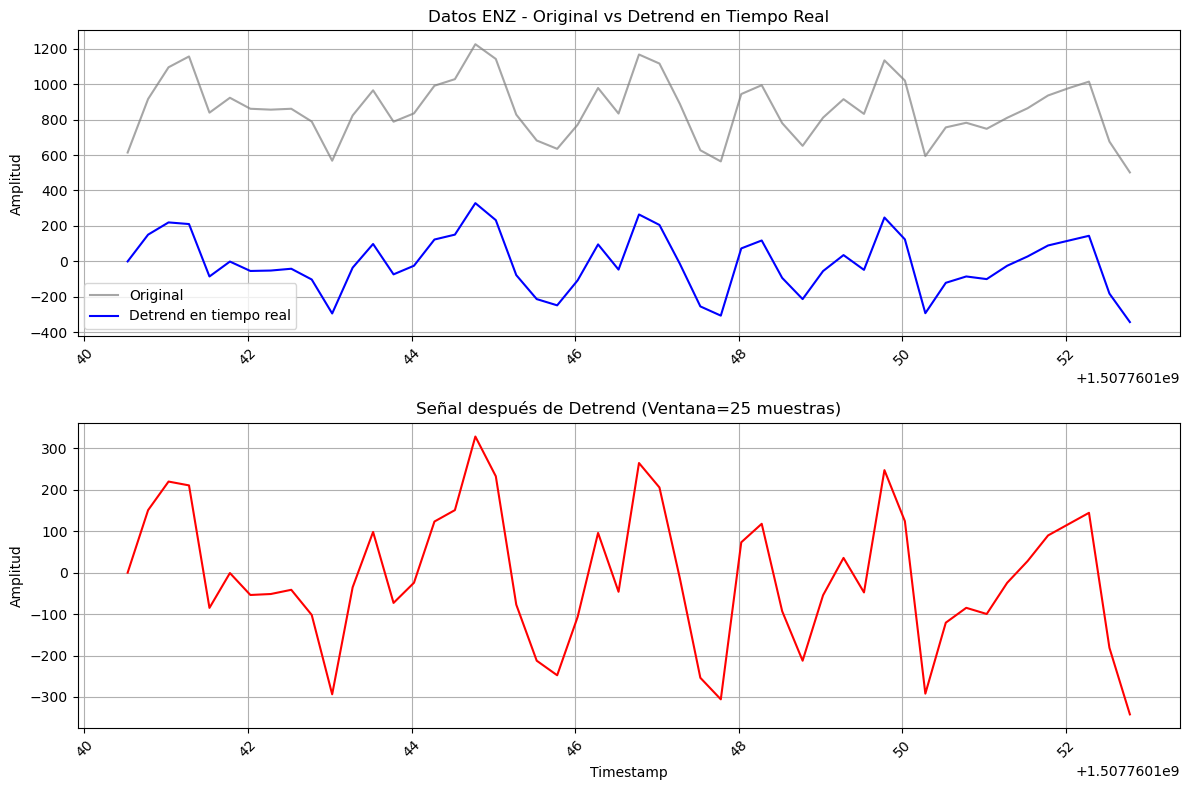

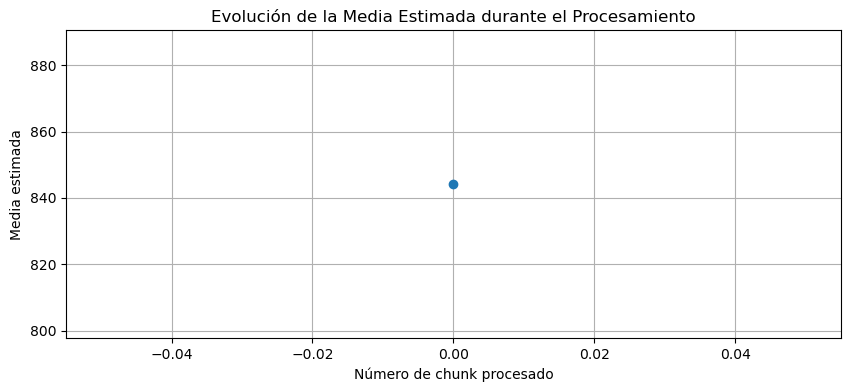

In [48]:
# Procesar el chunk ENZ real
enz_detrender = ENZSeismicDetrender(window_size=25, sampling_rate=4.0)
result = enz_detrender.process_enz_chunk(enz_chunk)

print("Resultado del procesamiento:")
for key, value in result.items():
    print(f"{key}: {value}")

# Mostrar estadísticas resumen
summary = enz_detrender.get_summary_stats()
print(f"\nEstadísticas resumen:")
for key, value in summary.items():
    print(f"{key}: {value}")

# Visualizar resultados
plt.figure(figsize=(12, 8))

# Gráfico 1: Datos originales vs detrended
plt.subplot(2, 1, 1)
plt.plot(enz_detrender.timestamps, data, 'gray', alpha=0.7, label='Original')
plt.plot(enz_detrender.timestamps, enz_detrender.processed_data, 'b-', label='Detrend en tiempo real')
plt.title('Datos ENZ - Original vs Detrend en Tiempo Real')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Gráfico 2: Solo datos detrended
plt.subplot(2, 1, 2)
plt.plot(enz_detrender.timestamps, enz_detrender.processed_data, 'r-')
plt.title('Señal después de Detrend (Ventana=25 muestras)')
plt.xlabel('Timestamp')
plt.ylabel('Amplitud')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Mostrar la evolución de la media estimada
means = [s.get('current_mean', 0) for s in enz_detrender.processing_stats if s.get('success', False)]
if means:
    plt.figure(figsize=(10, 4))
    plt.plot(means, 'o-')
    plt.title('Evolución de la Media Estimada durante el Procesamiento')
    plt.xlabel('Número de chunk procesado')
    plt.ylabel('Media estimada')
    plt.grid(True)
    plt.show()

## Consideraciones de Implementación
### 1. Tamaño de Ventana
- Ventana pequeña: Responde rápido a cambios pero puede ser puede verse afectada por fluctuaciones temporales en lugar de capturar la tendencia real subyacente.
- Ventana grande: Suaviza mejor pero responde lento a cambios.

### 2. Optimizaciones
- Uso de cálculo incremental para mejor rendimiento.
- Implementación circular para eficiencia de memoria.


### Conclusión
El detrend en tiempo real es una técnica esencial para el procesamiento de señales sísmicas. La implementación presentada:

- Remueve eficientemente la componente DC y tendencias.

- Funciona en tiempo real con bajo overhead computacional.

- Se adapta a cambios en la tendencia de la señal.

- No es tan complejo de implementar y ajustar para diferentes aplicaciones.